In [2]:
import numpy as np
from numpy import pi, diff, random, inf
from astropy.io import fits
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import signal, optimize
from skimage.io import imread
from sklearn.cluster import KMeans

First, the LOS Doppler data is stored in a numpy array. The images are then spatially apodized using a two-dimensional cosine-bell taper (scipy.signal.tukey) of width of 10% of total pixels applied to each edge. The resulting image time series are then Fourier-transformed.  

In [3]:
image_data = np.load('C:/Users/shba3443/Desktop/neural_a2/Sunrise/McClure/doppler data/IMAX_Doppler_extended_obs.npy')
size_image = np.shape(image_data)

tY = signal.tukey(size_image[1],alpha=.1) # Spatial shape parameter of Tukey window, also known as a tapered cosine window, along Y-axis.
tX = signal.tukey(size_image[2],alpha=.1) # Spatial shape parameter of Tukey window along X-axis.
tuk2d = np.sqrt(np.outer(tY,tX))
    
arr = []
for n in image_data:
    arr.append((n)*tuk2d) # Applying Tukey Window on the Image data.
    
arr = np.array(arr)
f = np.fft.fft(np.fft.fft(arr,axis=2),axis=1)     # Compute discrete Fourier Transform.
image_fft = np.fft.fftshift(np.fft.fft(f,axis=0)) # Shifting the zero-frequency component to the center of the spectrum.

The Fourier-transformed datacubes are 3D with 1-dimension corresponding to frequency and other 2-dimensions corresponding to the inverse of spatial scale. Here, the 2 spatial dimensions will be collapsed to 1D by appplying an averaging along the radius in the Fourier-space. In the first cell below, the 2D inverse spatial coordinates are transformed in to 1D inverse radial coordinate. In the next cell, power vs inverse radial coordinate vs frequencies are calculated. Finally, the 3rd cell displays the 2D plot of power vs spatial and temporal frequencies, also known as k-ω diagram.    

In [4]:
kmPix = 42 # Spatial Resolution of IMaX observation
sCad  = 33 # Temporal Resolution of IMaX observation

nx    = np.fft.fftshift(np.fft.fftfreq(size_image[1], d=kmPix)) # Discrete Fourier Transform sample frequencies in space.
ny    = np.fft.fftshift(np.fft.fftfreq(size_image[2], d=kmPix)) # Discrete Fourier Transform sample frequencies in space.
omega = np.fft.fftshift(np.fft.fftfreq(size_image[0], d=sCad))  # Discrete Fourier Transform sample frequencies in time.

xv, yv = np.meshgrid(nx, ny) # coordinate matrices in the Fourier space

# Function to calculate radius from 2D coordinates
def radius_calc(x_coord,y_coord):
    return np.sqrt(x_coord**2 + y_coord**2)

radius = radius_calc(xv,yv)  # corresponding radius matrices in the Fourier space
rad_range = np.linspace(np.min(radius),np.max(radius),int(np.shape(radius)[0]/4)) # Discretizing the radius along 1D 

del_omega = omega[1] - omega[0]
del_rad   = rad_range[1] - rad_range[0]

In [5]:
rad_kw = np.zeros((np.shape(image_fft)[0],np.shape(rad_range)[0]-1))  # initializing 2D array to store Power at different freuencies and inverse spatial scale      
for i_time in range (np.shape(image_fft)[0]):                         # For-loop for each freuencies and inverse spatial scale to store Power in the 2D matrix
    for i_rad in range (np.shape(rad_range)[0]-1):
        j,k = np.where((radius > rad_range[i_rad]) & (radius < rad_range[i_rad+1])) # Indices to find Power for a given range of inverse spatial scale
        rad_kw[i_time,i_rad]   = np.mean(np.abs(image_fft[i_time,j,k]))             # Average power along those indices
        
# Since the total power varies several orders of magnitude, the Log of Power is calculated and will be used for further analysis
log_rad_kw = np.log10(rad_kw[int(np.shape(image_data)[0]/2):int(np.shape(image_data)[0]/2) + int(np.shape(image_data)[0]/4),:int(np.shape(rad_kw)[1]/4)])

Text(0, 0.5, 'Frequency ($\\mathregular{mHz}$)')

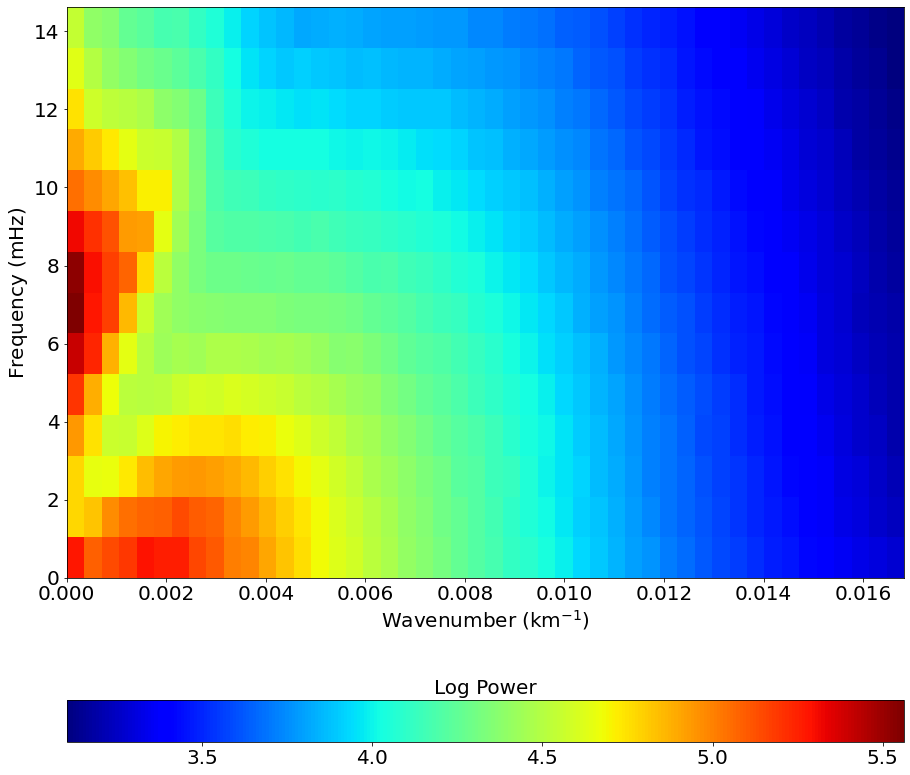

In [6]:
fig = plt.figure(figsize=(15,15))
plt.imshow(log_rad_kw,aspect='auto',cmap = 'jet',origin = 'lower', extent=[np.min(rad_range),np.max(rad_range),0,np.max(omega)*1000])
clb = plt.colorbar(orientation='horizontal',aspect=20);
clb.ax.set_title('Log Power', fontsize=20)
clb.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Wavenumber ($\mathregular{km^{-1}}$)', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Frequency ($\mathregular{mHz}$)', fontsize=20)

The k-ω diagram is saved as an image file, and as we can see from the diagram, the major power concentration is splitted in two areas and they can be clustered using standard clustering algorithms e. g. K-means clustering. To cluster the k-ω diagram, the saved image is retrieved and stored in a Pandas dataframe. The dataframe consists of 3 columns each dedicated to channels of different colors. The dataframe stores the RGB values in these columns for each pixel of the k-ω diagram image. Once, the dataframe is prepared, k-means clustering is applied. 

In [7]:
plt.imsave('fft_filter.png', log_rad_kw, cmap=plt.cm.jet)

def image_to_pandas(image):
    df = pd.DataFrame([image[:,:,0].flatten(),
                       image[:,:,1].flatten(),
                       image[:,:,2].flatten()]).T
    df.columns = ['Red_Channel','Green_Channel','Blue_Channel']
    return df

island = imread('fft_filter.png')
df_island = image_to_pandas(island) # Preparing data for k-means clustering 

kmeans = KMeans(n_clusters=5, random_state = 42).fit(df_island)   # number of clusters chosen iteratively until a proper clustering is achieved
result = kmeans.labels_.reshape(island.shape[0],island.shape[1])

Text(0, 0.5, 'Frequency ($\\mathregular{mHz}$)')

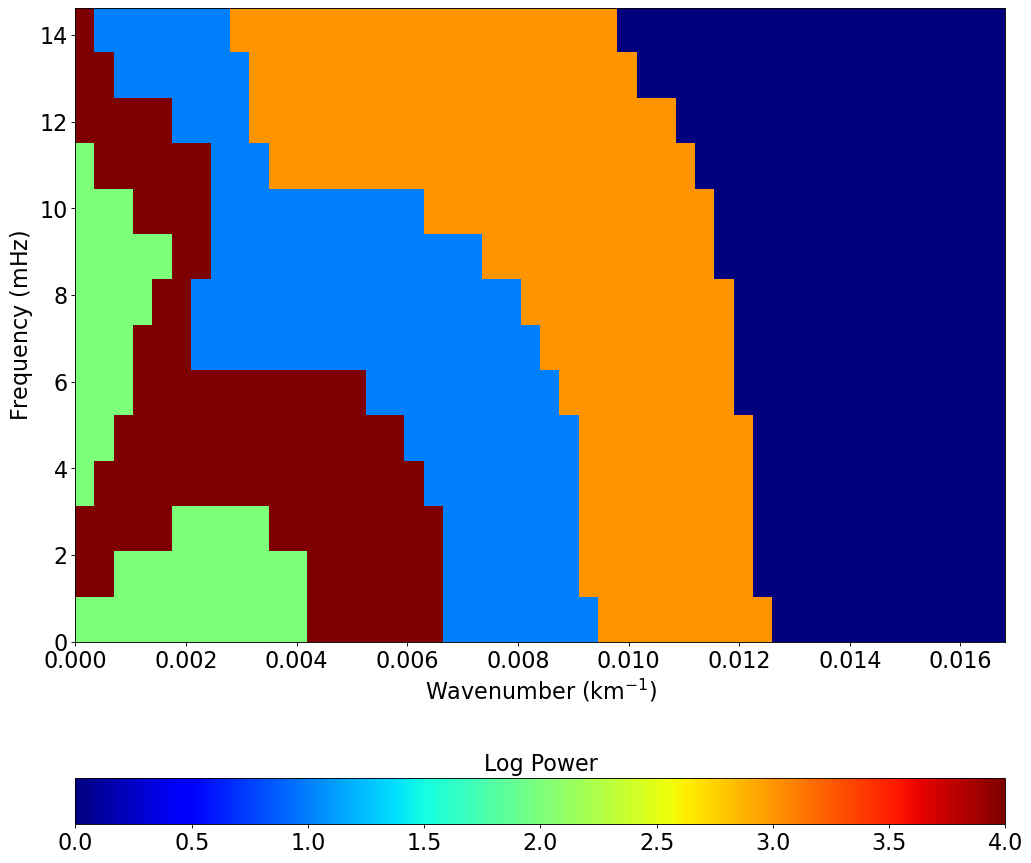

In [8]:
plt.figure(figsize=(15, 15), dpi=80)
plt.imshow(result, aspect='auto', cmap = 'jet', origin = 'lower', extent=[np.min(rad_range),np.max(rad_range),0,np.max(omega)*1000]);
clb = plt.colorbar(orientation='horizontal',aspect=20);
clb.ax.set_title('Log Power', fontsize=20)
clb.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Wavenumber ($\mathregular{km^{-1}}$)', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Frequency ($\mathregular{mHz}$)', fontsize=20)

The clustered data show 5-principal clusters. By comparing it with the k-ω diagram, it is evident that only the cluster 2 corresponds to the regions of strong concentration of power from the spectrum. Thus, the other 4 clusters (assigned as [0,1,3,4]) are discarded and the cluster assigned as [2] is amplified and the corresponding pixel-coordinates are stored.   

In [9]:
result[result == 2] = 10
result[result < 5]  = 0

ii = np.where(result == 10)
x0 = ii[0]
y0 = ii[1]

Next, we want to draw a line between the clustered regions, so that we can filter these two portions autonomously. Here the line goes through the center and so it can be expressed as y = mx. In the following cell, we determine "m" by finding the minimum standard deviation of the distances calculated between the points in the cluster and the line itself (Formula: https://en.wikipedia.org/wiki/Distance_from_a_point_to_a_line). 

In [10]:
def f(m):
    d = np.abs((m)*x0-y0)/np.sqrt((m)**2+1)
    return np.std(d)

minimum = optimize.fmin(f, x0=0) # Minimize the function using the downhill simplex algorithm.
slope = minimum[0]               # determining "m" of the line y = mx.

# x and y axis for plotting the line on top of the clustered region.
xline_for_slope = rad_range[:int(np.shape(rad_range)[0]/4)]
yline_for_slope = (slope*xline_for_slope)/del_omega

Optimization terminated successfully.
         Current function value: 1.783790
         Iterations: 25
         Function evaluations: 50


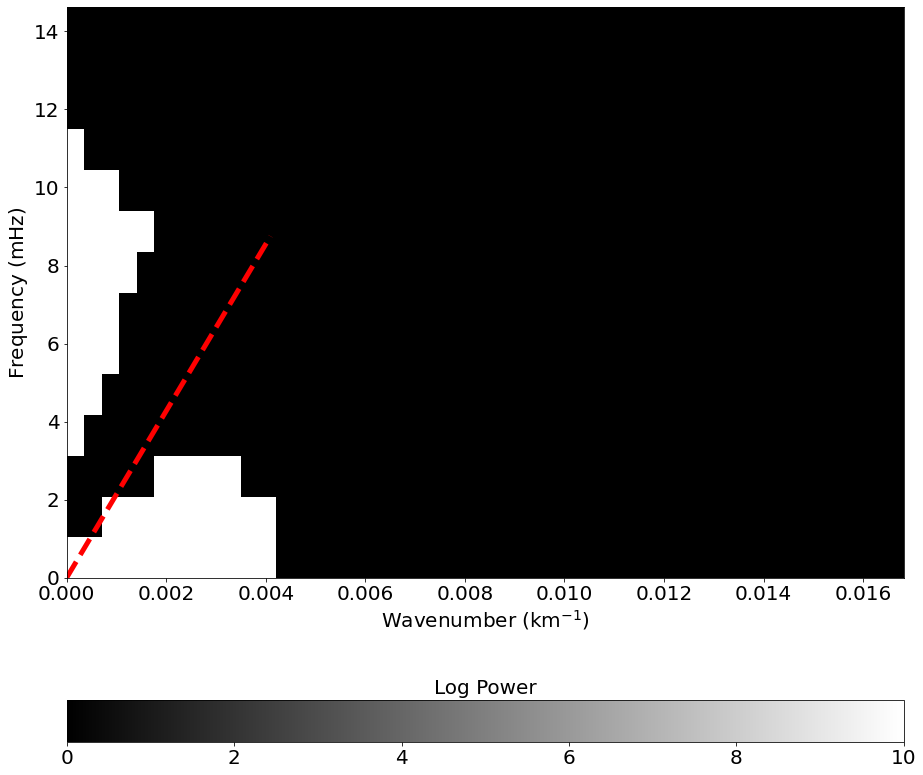

In [11]:
plt.figure(figsize=(15, 15))
plt.imshow(result, aspect='auto',origin = 'lower',cmap = 'gray', extent=[np.min(rad_range),np.max(rad_range),0,np.max(omega)*1000]);
clb = plt.colorbar(orientation='horizontal',aspect=20);
clb.ax.set_title('Log Power', fontsize=20)
clb.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Wavenumber ($\mathregular{km^{-1}}$)', fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('Frequency ($\mathregular{mHz}$)', fontsize=20)
plt.plot(xline_for_slope, yline_for_slope, '--r', linewidth = 5)

Since, the line is drawn in the k-ω diagram (frequency and 1/wavelength), it corresponds to a speed. This speed to filter the two regions of spectral power concetration can be readily calulated from the slope of the line we deduced above. In addition, to filter any region of the clusters, we need to know the speed for each pixels in the k-ω diagram. This is also calculated in the cell below.

In [12]:
# speed to filter the two regions of spectral power concetration
filter_speed = slope*del_omega/del_rad 

# speed for each pixels in the k-ω diagram
kw_speed = np.zeros_like(image_fft)
for i in range (np.shape(kw_speed)[0]):
    kw_speed[i,:,:] = np.abs(omega[i]/radius)

C:\Users\shba3443\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys
C:\Users\shba3443\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


Once the speed at each pixels in the k-ω diagram is known, the image time series in the FFT-space is filtered and two sources (slower one corresponding to the convective motion) of LOS Doppler contribution are separeted successfully.

In [13]:
f_mode = np.copy(image_fft)
i,j,k = np.where(np.real(kw_speed) < filter_speed)     # modal contributions are usally considered to be the faster one in the LOS Doppler contribution. 
f_mode[i,j,k] = 0
mode = np.fft.ifftn(np.fft.ifftshift(f_mode))          # Compute the N-dimensional inverse discrete Fourier Transform.
filtered_mode = np.real(mode)

f_gran = np.copy(image_fft)
i,j,k = np.where(np.real(kw_speed) > filter_speed)     # Convective motion (granulations) is the relatively slower in terms of the LOS Doppler contribution.
f_gran[i,j,k] = 0
gran = np.fft.ifftn(np.fft.ifftshift(f_gran))         # Compute the N-dimensional inverse discrete Fourier Transform.
filtered_gran = np.real(gran)

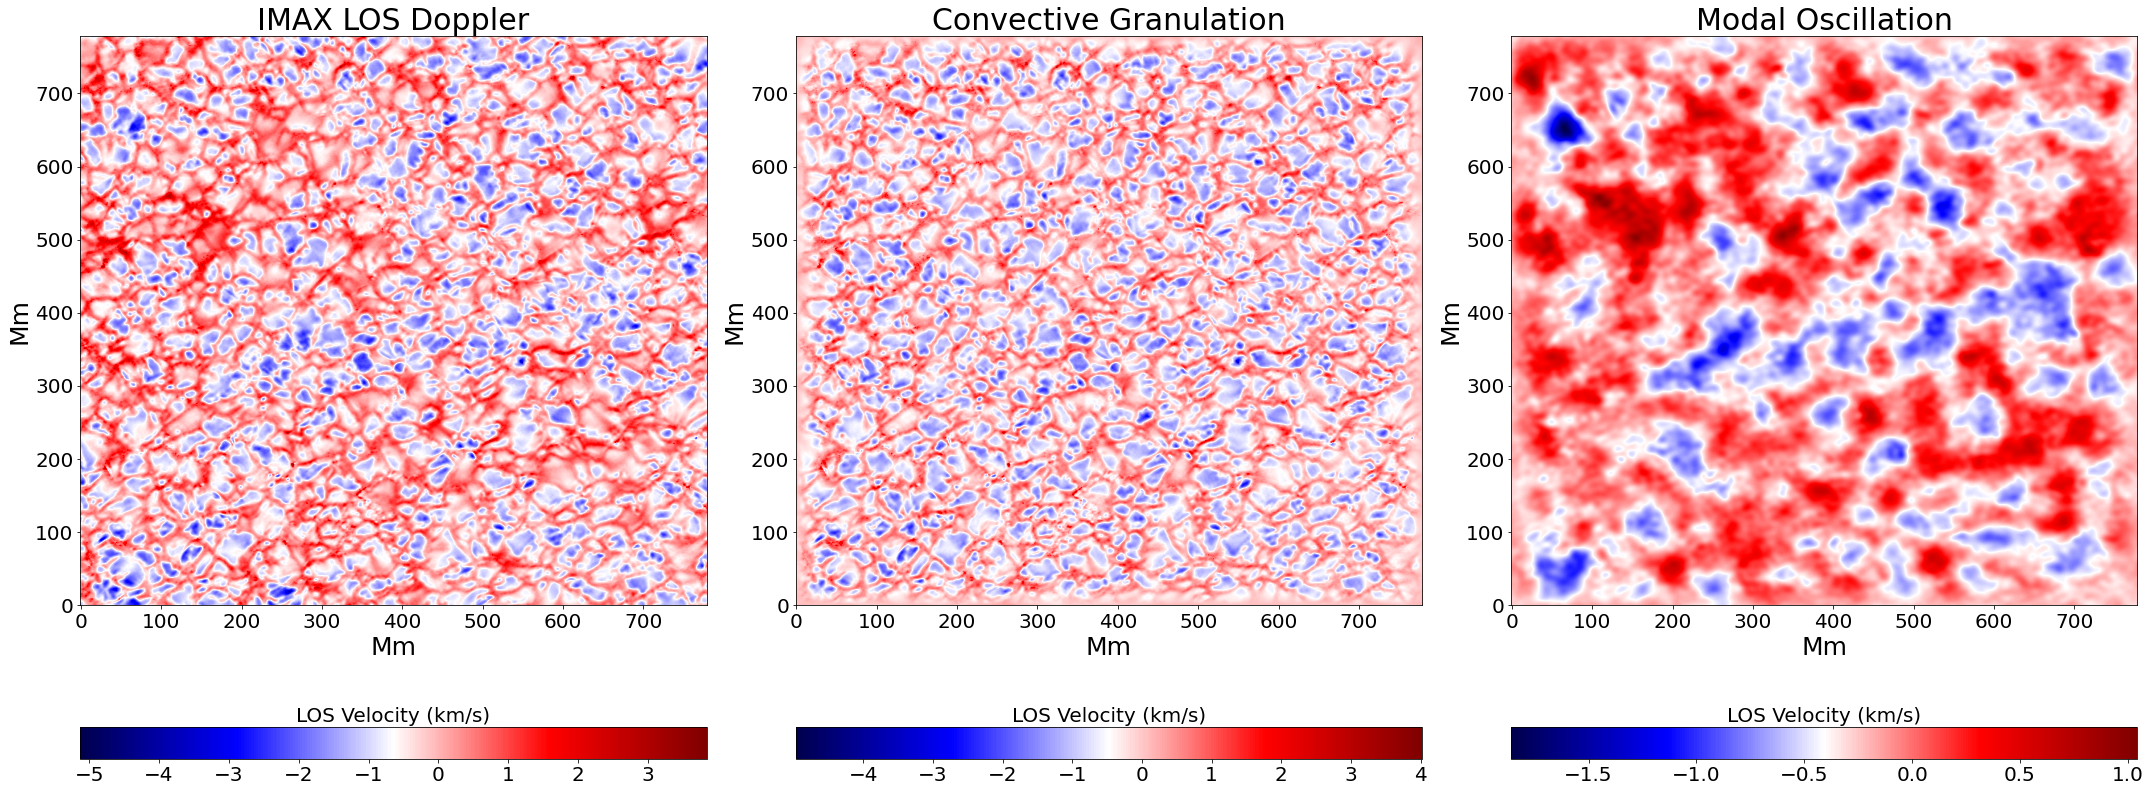

In [14]:
plt.figure(figsize=(30, 12))
plt.subplot(1, 3, 1)
plt.imshow(image_data[10,:,:], aspect='auto', cmap = 'seismic', origin = 'lower');
clb = plt.colorbar(orientation='horizontal',aspect=20);
clb.ax.set_title('LOS Velocity (km/s)', fontsize=20)
clb.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Mm', fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel('Mm', fontsize=25)
plt.title('IMAX LOS Doppler', fontsize=30)

plt.subplot(1, 3, 2)
plt.imshow(filtered_gran[10,:,:], aspect='auto', cmap = 'seismic', origin = 'lower');
clb = plt.colorbar(orientation='horizontal',aspect=20);
clb.ax.set_title('LOS Velocity (km/s)', fontsize=20)
clb.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Mm', fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel('Mm', fontsize=25)
plt.title('Convective Granulation', fontsize=30)

plt.subplot(1, 3, 3)
plt.imshow(filtered_mode[10,:,:], aspect='auto', cmap = 'seismic', origin = 'lower');
clb = plt.colorbar(orientation='horizontal',aspect=20);
clb.ax.set_title('LOS Velocity (km/s)', fontsize=20)
clb.ax.tick_params(labelsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Mm', fontsize=25)
plt.yticks(fontsize=20)
plt.ylabel('Mm', fontsize=25)
plt.title('Modal Oscillation', fontsize=30)

plt.tight_layout()